In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import os
import pickle
from pickle import load
from pickle import dump
from numpy import argmax
from os import listdir
import nltk
from IPython.display import Image

nltk.download('punkt')
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

from google.colab.patches import cv2_imshow
import numpy as np
import cv2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## generateCaptions class functions

- __init__(): initialize the object with datapaths
- loadInputData(): Load all the pickled data files created before.
- readFiles(): Helper function to read pkl files.
- getTestImageNames(), objectDetection(): These files are used to load the test image files from "Flickr_8k.testImages.txt" and extract feautures respectively, However this pkl file has been created and imported to save run time.
- getMaxLengthDesc(): Get the length of the longest description.
- loadModel(): Load the rnn model with the least loss generated in one of the epochs.
- createCaptions(): Captions are created by mentioning a start token for every caption. This word is then padded with zeros with the length of the maximum description. This is then passed to the rnn model along with the feature vector of the particular image. The rnn model then prints out a numpy array of possible words probabilities for this word and the image features. The word corresponding to the maximum probability is then extracted from the tokenizer and returned as the next word. If no word is returned then the caption generation is stopped since the word is not present in the vocabulary. If endtoken is returned then the caption generation is stopped signifying sentence has ended.
- display_image(): Helper class function for displaying images and their captions.  
- display_samples(): Takes a provided number, and displays the image and captions for those number of images.

In [0]:
class generateCaptions:
    def __init__(self):
        self.dirPath = "/content/drive/My Drive/NLP_Project/ProjectCode"
        self.dataPath = "/content/drive/My Drive/NLP_Project/ProjectCode/dataset"
        self.imgPath = "/content/drive/My Drive/NLP_Project/ProjectCode/dataset/Flicker8k_Dataset"
        self.modelsPath = "/content/drive/My Drive/NLP_Project/ProjectCode/models"
        self.lstmModelsPath = "/content/drive/My Drive/NLP_Project/ProjectCode/models/lstmModels"
        self.descFile = "Flickr8k.token.txt"
        self.trainDataFile = "Flickr_8k.trainImages.txt"
        self.testDataFile = "Flickr_8k.testImages.txt"
        self.testImgNames=[]
        self.descriptionData={}
        self.vocabulary=[]
        self.testImages={}
        self.vggmodel = VGG16()
    
    def loadInputData(self):
        self.tokenizer = self.readFiles("trainTokens.pkl")
        # self.imageData = self.readFiles("imageObjects.pkl")
        self.descriptionData = self.readFiles("trainDescription.pkl")
        self.vocabulary = self.readFiles("trainVocabulary.pkl")
        self.testImages = self.readFiles("TestimageObjects.pkl")
        # self.sample_images = self.readSample()
        # return self.tokenizer, self.imageData, self.descriptionData, self.vocabulary

    def readFiles(self,fileName):
        with open(self.modelsPath+"/"+fileName, 'rb') as f:
            inputData = pickle.load(f)
        return inputData

    def getTestImageNames(self):
        file = open(self.dataPath+"/"+self.testDataFile, 'r')
        # self.testImgNames = []
        for line in file.read().split("\n"):
          self.testImgNames.append(line)
        file.close()
    
    def objectDetection(self):
      objectsDict = {}
      i = 0
      
      self.getTestImageNames()
      
      self.vggmodel.layers.pop()
      self.vggmodel = Model(inputs=self.vggmodel.inputs, outputs=self.vggmodel.layers[-1].output)

      for imgName in self.testImgNames:
          # if i < 6000:
          if imgName.strip() is not None:
              img = cv2.imread(os.path.join(self.imgPath,imgName))
              if(img is not None):
                  img = cv2.resize(img,(224,224))
                  img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
                  img = preprocess_input(img)
                  objectsDict[imgName] = self.vggmodel.predict(img, verbose = 0)
                  # print(i, end=" , ")
                  # if(i%100 == 0):
                  #     print(" \n")
          i+=1

      dump(objectsDict, open(self.modelsPath+'/TestimageObjects.pkl', 'wb'))
      print("done!")
      self.testImages = self.readFiles("TestimageObjects.pkl")

    def getMaxLengthDesc(self):
        self.allDescriptionsLen = []
        self.allDescriptions = []

        for values in self.descriptionData.values():
            # add all the lengths of the descriptions
            self.allDescriptions.extend((nltk.word_tokenize(value)) for value in values)
            self.allDescriptionsLen.extend(len(nltk.word_tokenize(value)) for value in values)
            
        self.maxlen = max(self.allDescriptionsLen)
        # return self.maxlen

    def loadModel(self, model_number):
        self.rnnmodel = load_model(self.lstmModelsPath+'/'+model_number)

    def createCaptions(self):
        self.getMaxLengthDesc()
        count=0
        self.captions=dict()
        for image in self.testImages:
          start = 'starttoken'
          for i in range (self.maxlen):
              sent = self.tokenizer.texts_to_sequences([start])[0]
              padded_seq= pad_sequences([sent], maxlen = self.maxlen)
              predict= self.rnnmodel.predict([self.testImages[image],padded_seq], verbose=0)
              predict_next = argmax(predict)
              next_word = ''
              for key,value in self.tokenizer.word_index.items():
                if value == predict_next:
                    next_word = key
              if next_word =='':
                  break
              start += ' ' + next_word
              if next_word == 'endtoken':
			            break

          self.captions[image] = start
          count = count+1
          # if count%10==0:
          #     print(count)
        print("Captions generated")
        # return self.captions 

    def display_image(self, filename,caption):
        image = mpimg.imread(self.imgPath+'/'+filename)
        plt.figure()
        plt.imshow(image)
        print(caption)
        plt.show()
        print()

    def display_samples(self, num):
        sample = dict(list(self.captions.items())[0: num])   
        for key,value in sample.items():
            self.display_image(key,value)


In [0]:
model = generateCaptions()

In [0]:
model.loadInputData()
# model.objectDetection()
model.loadModel('LSTM_MODEL_9.h5')

In [51]:
model.createCaptions()

Captions generated


starttoken two dogs are running through the grass endtoken


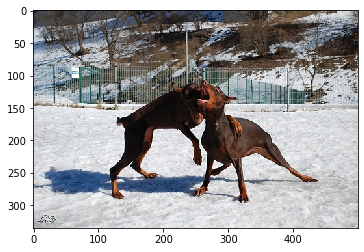


starttoken two children are playing in the water endtoken


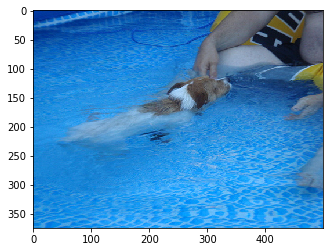


starttoken man in black shirt is standing on the street endtoken


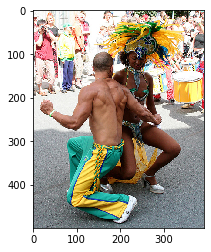


starttoken man in red shirt is standing on top of street endtoken


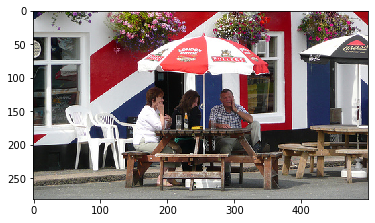


starttoken two men playing soccer on field endtoken


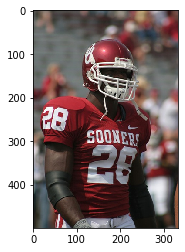


starttoken dog is running through the grass endtoken


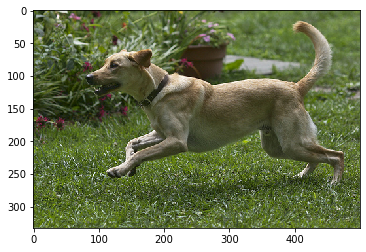


starttoken two girls are sitting on table endtoken


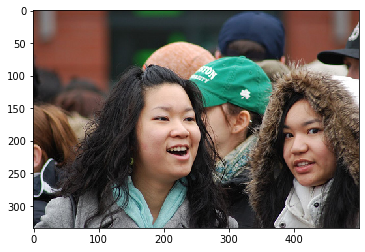


starttoken dog is running through the grass endtoken


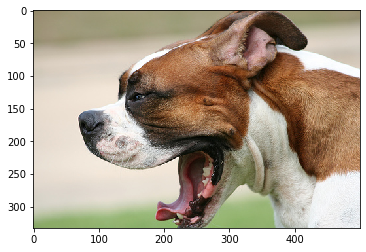


starttoken two dogs are running through the grass endtoken


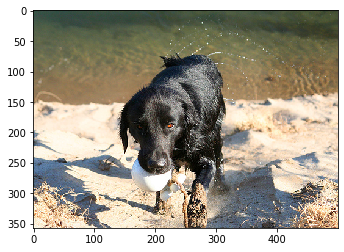


starttoken two men playing soccer on field endtoken


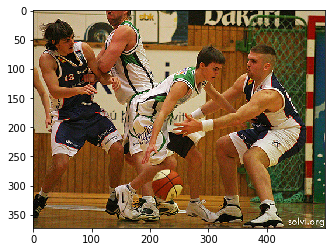

In [0]:
model.display_samples(10)

The output currently is not accurate however it manages to get the context of the image in consideration which is a good sign. We will fine tune the model and run it for more epochs to get more accurate output.